In [1]:
import json
import os
import shutil
import warnings
from datetime import datetime
from os.path import exists

In [2]:
import joblib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import tensorflow_hub as hub
from pandas import DataFrame
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from stackapi import StackAPI

2024-09-06 12:01:13.144969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 12:01:13.156919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 12:01:13.160367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 12:01:13.170036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 12:01:14.038363: W tensorflow/compiler/tf2

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

STACKAPI CONFIGURATION

In [4]:
SITE = StackAPI('stackoverflow')
SITE.max_pages = 25

MISC CONFIGURATION

In [5]:
plt.style.use("fivethirtyeight")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

PATHS

In [6]:
CACHED_2023_QUESTIONS_FILE = 'cached_questions_2023.json'
MODEL_PATH = 'models/supervised/best_supervised_model.model'
TAGS_PATH = 'models/supervised/tags.json'

USE ENCODER

In [7]:
use_encoder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

I0000 00:00:1725598875.759137  136732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725598875.808549  136732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725598875.811630  136732 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725598875.815327  136732 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

MLFlow

In [8]:
mlflow.set_tracking_uri(uri="http://localhost:8080")
mlflow.set_experiment("Stability Verification Experiment")

2024/09/06 12:01:19 INFO mlflow.tracking.fluent: Experiment with name 'Stability Verification Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/402689750706285830', creation_time=1725598879125, experiment_id='402689750706285830', last_update_time=1725598879125, lifecycle_stage='active', name='Stability Verification Experiment', tags={}>

In [9]:
def cache_questions_from_2023():
    """Fetches the questions of a given month with at least 10 votes."""
    # https://stackapi.readthedocs.io/en/latest/user/complex.html
    questions = SITE.fetch('questions',
                           fromdate=datetime(2023, 1, 1),
                           todate=datetime(2023, 12, 31),
                           min=10,
                           sort='votes',
                           filter='withbody'
                           )
    extracted_questions = questions['items']
    
    questions = [{
        "body": question['body'],
        "creation_date": question['creation_date'],
        "score": question['score'],
        "tags": question['tags'],
        "title": question['title']
    } for question in extracted_questions]
    
    with open(CACHED_2023_QUESTIONS_FILE, 'w', encoding='utf-8') as f:
        json.dump(questions, f, ensure_ascii=False, indent=4)

In [10]:
def add_datetime_to_question(question: dict):
    """Add a datetime field to the question."""
    question['creation_datetime'] = datetime.fromtimestamp(question['creation_date'])
    return question

In [11]:
def count_cached_questions_per_year():
    """Displays each year's number of cached questions."""
    with open('cached_questions.json', 'r', encoding='utf-8') as f:
        questions = json.load(f)
        
        min_timestamp = min([question['creation_date'] for question in questions])
        min_datetime = datetime.fromtimestamp(min_timestamp)
        
        max_timestamp = max([question['creation_date'] for question in questions])
        max_datetime = datetime.fromtimestamp(max_timestamp)
        
        print(f"The cached questions range from {min_datetime} to {max_datetime}.\n")
        
        enriched_questions = list(map(add_datetime_to_question, questions))
        
        for year in range(2010, 2024):
            number_of_questions_for_year = len([question for question in enriched_questions if question['creation_datetime'].year == year])
            print(f"Number of questions for year {year}: {number_of_questions_for_year}")

In [12]:
def count_cached_questions_per_month(questions):
    """Displays each year's number of cached questions."""
    min_timestamp = min([question['creation_date'] for question in questions])
    min_datetime = datetime.fromtimestamp(min_timestamp)
    
    max_timestamp = max([question['creation_date'] for question in questions])
    max_datetime = datetime.fromtimestamp(max_timestamp)
    
    print(f"The cached questions range from {min_datetime} to {max_datetime}.\n")
    
    for month in range(1, 13):
        number_of_questions_for_month = len([question for question in questions if question['creation_datetime'].month == month])
        print(f"Number of questions for month {month}: {number_of_questions_for_month}")

In [13]:
def load_cached_2023_questions():
    """Load questions from the cache file."""
    with open(CACHED_2023_QUESTIONS_FILE, 'r', encoding='utf-8') as f:
        return json.load(f)

In [14]:
def start_label_binarizer(json_tags):
    """Initializes the label binarizer"""
    tags_df = pd.Series(json_tags)
    
    multi_label_binarizer = MultiLabelBinarizer()
    multi_label_binarizer.fit(tags_df)
    
    return multi_label_binarizer

In [15]:
def transform_text_using_USE(sentences):
    """Transform the text of the question's body and title into USE embeddings."""
    # We don't want to use the cleaned text field with USE, only title + " " + body
    sentences = [f"{sentence[1]} {sentence[0]}" for sentence in sentences.iterrows()]
    batch_size = 1
    
    for step in range(len(sentences) // batch_size):
        idx = step * batch_size
        feat = use_encoder(sentences[idx:idx + batch_size])
        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))
            
    return features

In [16]:
def create_results_plots(results):
    """Generate the plot showing the performances with each words embedding method for the Jaccard Score and Hamming Loss."""
    create_results_plot(results, "jaccard_score")
    create_results_plot(results, "hamming_loss")

In [17]:
def create_results_plot(results, metric):
    """Create results plot for a single metric."""
    performance_plot = (results[[metric, "month"]]
                        .plot(kind="bar", x="month", figsize=(15, 8), rot=0,
                              title=f"Models Performance Sorted by {metric}"))
    performance_plot.title.set_size(20)
    performance_plot.set(xlabel=None)
    
    plt.show()
    plt.close()

In [18]:
def send_scores_to_mlflow(last_result):
    """Send the scores to MLFlow."""
    with mlflow.start_run():
        mlflow.log_params({
            "month": last_result['month']
        })
        
        mlflow.log_metric("hamming_loss", last_result['hamming_loss'])
        mlflow.log_metric("jaccard_score", last_result['jaccard_score'])

Starting stability verification script.


Number of questions of 2023 with a minimum of 10 votes: 2153.

Starting month:1 verification with 275 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['amazon-eks', 'android-studio-electric-eel', 'angular-standalone-components', 'angular14', 'angular15', 'antd', 'astronomy', 'avx2', 'avx512', 'aws-cdk', 'aws-sam-cli', 'azure-ad-msal', 'azure-cognitive-services', 'azure-databricks', 'azure-openai', 'bert-language-model', 'blazor-webassembly', 'buildx', 'bun', 'c++23', 'cmake-presets', 'codeigniter-3', 'configurationproperties', 'css-in-js', 'cyclic-reference', 'cypress-log', 'dnspython', 'dvc', 'eksctl', 'facebook-prophet', 'flask-socketio', 'flutter-go-router', 'flutter-hive', 'fmt', 'fsspec', 'gcp-load-balancer', 'github-copilot', 'github-organizations', 'gitlab-ci.yml', 'golint', 'google-cloud-networking', 'google-cloud-run', 'google-play-integrity-api', 'hashicorp', 'huggingface', 'huggingface-tokenizers', 'imagick', 'integer-promotion', 'ipados', 'isort', 'jakarta-migration', 'jpa-buddy'

Results of month:1 - Hamming loss:0.00027366020524515394, jaccard_score:0.10570562770562769.

Starting month:2 verification with 242 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['amazon-eks', 'android-jetpack-compose-material3', 'android-livedata-transformations', 'android-studio-electric-eel', 'angular15', 'anr', 'asp.net-core-7.0', 'asp.net-core-viewcomponent', 'asynchronous-method-call', 'avif', 'buildx', 'charles-proxy', 'clap', 'composable', 'database-deployment', 'discord', 'dj-rest-auth', 'django-crispy-forms', 'eas', 'ef-core-7.0', 'eslint-flat-config', 'flutter-local-notification', 'flutter-platform-channel', 'flutter-stacked', 'formattablestring', 'fpm', 'frontend', 'geocoder', 'github-actions-workflows', 'github-copilot', 'google-mlkit', 'gpt-3', 'graphql-flutter', 'igraph', 'iis-express-10', 'kaniko', 'laravel-10', 'laravel-9', 'laravel-livewire', 'macos-ventura', 'mamba', 'mambaforge', 'mediatr', 'nats-jetstream', 'nats.io', 'next-auth', 'next.js13', 'numba', 'nuxt3.js', 'pandasql', 'pinia', 'pnpm', 'post

Results of month:2 - Hamming loss:0.0002805651052397568, jaccard_score:0.12555096418732783.

Starting month:3 verification with 263 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['amazon-eks', 'android-compose-layout', 'android-jetpack-compose-material3', 'angular-standalone-components', 'appkit', 'approximation', 'auto-vectorization', 'aws-cdk', 'azure-ad-msal', 'azure-pipelines-yaml', 'bitbucket-pipelines', 'buildx', 'c++-modules', 'c++26', 'data-distribution-service', 'discord', 'distributed-training', 'docker-daemon', 'eslint-plugin-import', 'fips', 'flutter-dialog', 'flutter-go-router', 'flutter-in-app-purchase', 'fortify-source', 'frontend', 'github-copilot', 'google-admin-sdk', 'google-analytics-4', 'google-artifact-registry', 'google-play-integrity-api', 'google-workspace', 'gpt-3', 'gpt-4', 'grails-plugin', 'hotwire-rails', 'huggingface', 'io-uring', 'javascript-debugger', 'knex.js', 'laravel-10', 'launchdarkly', 'mac-catalyst', 'mdspan', 'mediatr', 'mermaid', 'microsoft-graph-api', 'monaco-editor', 'mt19937',

Results of month:3 - Hamming loss:0.0002786579172547584, jaccard_score:0.06761723700887198.

Starting month:4 verification with 226 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['android-jetpack-compose-canvas', 'android-jetpack-compose-material3', 'android-r8', 'android-security', 'apache-commons-email', 'asdf', 'astrojs', 'aws-cloudmap', 'aws-event-bridge', 'aws-service-connect', 'azure-functions-runtime', 'azure-managed-identity', 'azure-powershell', 'birthday-paradox', 'capacitor', 'charmap', 'cicd', 'combn', 'compiler-specific', 'compose-recomposition', 'databricks', 'datadog', 'datadog-dashboard', 'direct-initialization', 'eslint-plugin-jsdoc', 'firefox-addon-webextensions', 'ggproto', 'gil', 'github-copilot', 'google-mlkit', 'huggingface', 'inspection', 'ionic6', 'itms90725', 'jakarta-migration', 'java-20', 'js-xlsx', 'kableextra', 'kingfisher', 'lda', 'loss', 'lost-focus', 'manifest.json', 'mobaxterm', 'modulenotfounderror', 'ms-clarity', 'navigationsplitview', 'neovim', 'neovim-plugin', 'netflix-metaflow', 'n

Results of month:4 - Hamming loss:0.0002738253260447789, jaccard_score:0.16262115465655286.

Starting month:5 verification with 221 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-4.8', '.net-sdk', 'amazon-linux-extras', 'android-external-storage', 'android-jetpack-datastore', 'android-r8', 'angular-resolver', 'angular-router-guards', 'angular-signals', 'angular16', 'app-router', 'arduino-esp8266', 'arrayofarrays', 'azure-databricks', 'background-task', 'bitbucket-api', 'buildx', 'c++-modules', 'c++23', 'c23', 'chromadb', 'cicd', 'clap', 'clerk', 'compiler-specific', 'cortex-m', 'crash-reports', 'cublas', 'dbatools', 'docker-engine', 'document-loader', 'drupal-7', 'drupal-modules', 'esp8266', 'esptool', 'firebase-admin', 'flutter3.x', 'frontend', 'fseek', 'github-copilot', 'google-cloud-dataproc', 'google-cloud-vertex-ai', 'gpt-3', 'hibernate-criteria', 'inf', 'ios16.4', 'iteritems', 'itext7', 'jackson-databind', 'java-19', 'kubeflow', 'kubeflow-pipelines', 'neovim', 'netlify', 'next-auth', 'next.js13', 'ownership

Results of month:5 - Hamming loss:0.0002706395489278312, jaccard_score:0.10030165912518854.

Starting month:6 verification with 172 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-8.0', 'ackermann', 'aem', 'android-14', 'android-api-34', 'android-r8', 'android-securityexception', 'android-studio-flamingo', 'angular-in-memory-web-api', 'angular-standalone-components', 'angular12', 'angular13', 'antd', 'app-router', 'appintents', 'automatic-storage', 'avd-manager', 'aws-batch', 'azure-cli', 'azure-openai', 'build-runner', 'built-value', 'c++-attributes', 'c++23', 'chocolatey', 'compose-recomposition', 'consteval', 'cross-origin-opener-policy', 'dart-isolates', 'device-admin', 'docker-daemon', 'elastic-stack', 'esbuild', 'excel-365', 'fb-hydra', 'fine-tuning', 'frontend', 'github-actions-self-hosted-runners', 'github-copilot', 'hibernate-6.x', 'huggingface', 'huggingface-tokenizers', 'in-app-purchase-receipt', 'in-app-update', 'ios17', 'iterator-traits', 'language-model', 'libmysqlclient', 'lld', 'logstash-logback-en

Results of month:6 - Hamming loss:0.0002880760617230082, jaccard_score:0.11647286821705426.

Starting month:7 verification with 153 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-8.0', 'amazon-sagemaker', 'android-13', 'android-14', 'android-jetpack-compose-lazy-column', 'android-jetpack-compose-material3', 'android-mediaprojection', 'android-studio-giraffe', 'angular-standalone-components', 'angular16', 'appintents', 'aws-lambda-layers', 'c#-11.0', 'c++23', 'c++26', 'cft', 'chrome-for-testing', 'compose-recomposition', 'create-react-native-app', 'dependabot', 'docker-healthcheck', 'dpc++', 'eslint-flat-config', 'expo-router', 'fine-tuning', 'ghcr', 'github-copilot', 'gopls', 'health-check', 'huggingface', 'huggingface-tokenizers', 'igraph', 'ios17', 'kotlin-gradle-plugin', 'langchain-js', 'mamba', 'nativewind', 'next.js13', 'nextjs-dynamic-routing', 'ng-modules', 'nrwl-nx', 'nuxt3.js', 'observableobject', 'observation-framework', 'peft', 'pino', 'pinojs', 'playwright', 'private-inheritance', 'raku', 'react-forms

Results of month:7 - Hamming loss:0.000271681873398957, jaccard_score:0.13856209150326798.

Starting month:8 verification with 155 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-4.8', 'accelerate', 'amazon-sagemaker-studio', 'android-14', 'android-workmanager', 'appcenter', 'auto-vectorization', 'c++-modules', 'c17', 'c23', 'chromadb', 'cicd', 'clerk', 'compiler-specific', 'compose-multiplatform', 'dbi', 'default-interface-member', 'drizzle', 'edge-devtools', 'flutter-upgrade', 'foreground-service', 'gcc-statement-expression', 'github-fine-grained-tokens', 'github-packages', 'github-secret', 'google-meet', 'google-one-tap', 'huggingface', 'igraph', 'integer-promotion', 'ios17', 'jupyter-contrib-nbextensions', 'k3s', 'llama', 'llama-cpp-python', 'microsoft-teams', 'modulenotfounderror', 'next-auth', 'next.js13', 'openrewrite', 'python-polars', 'raku', 'rakudo', 'skia', 'spring-boot-3', 'std-ranges', 'streamlit', 'structured-data', 'swiftdata', 'system.threading.channels', 'visual-studio-app-center-distribute', 'v

Results of month:8 - Hamming loss:0.0002942582852098429, jaccard_score:0.0871505376344086.

Starting month:9 verification with 128 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-8.0', 'android-splashscreen', 'assumption', 'bun', 'c++23', 'chat-gpt-4', 'commonmark', 'compiler-specific', 'dbt', 'dio', 'glance', 'glance-appwidget', 'gpt-4', 'huggingface', 'huggingface-datasets', 'i18next', 'identitymodel', 'ios17', 'jetpack-compose-animation', 'jetpack-compose-modalbottomsheet', 'minimal-apis', 'mobile-development', 'mojolang', 'navigation-compose', 'observedobject', 'react-markdown', 'restrict-qualifier', 'rider', 'sentence-transformers', 'std-ranges', 'string-catalog', 'swiftdata', 'swiftui-sheet', 'virtual-threads', 'zod'] will be ignored
  warnings.warn(
2024/09/06 12:01:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-toad-178 at: http://localhost:8080/#/experiments/402689750706285830/runs/955694f42d0849a3920b42c293b67650.
2024/09/06 12:01:38 INFO mlflow.tracking._tracking_service.client: 

Results of month:9 - Hamming loss:0.00028101352752150926, jaccard_score:0.14082961309523812.

Starting month:10 verification with 126 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.env', '.net-8.0', '.net-generic-math', 'android-jetpack-compose-material3', 'attestations', 'biomart', 'c#-12.0', 'c++-modules', 'chromadb', 'customtkinter', 'dbplyr', 'flask-login', 'flutter-go-router', 'gcc-pedantic', 'gcloud-cli', 'github-copilot', 'google-ad-manager', 'gorouter', 'gpt-4', 'hibernate.cfg.xml', 'htmx', 'imp', 'ios17', 'java-http-client', 'llama', 'localbroadcastmanager', 'mobile-development', 'modulenotfounderror', 'msw', 'netplan', 'next.js13', 'non-breaking-characters', 'onbeforeunload', 'openvswitch', 'pnpm', 'project-loom', 'psycopg3', 'py-langchain', 'python-3.12', 'react-native-maps', 'ruby-on-rails-7', 'skfuzzy', 'spring-tools-4', 'std-ranges', 'swift-keypath', 'swift-macro', 'swiftdata', 'virtual-threads', 'virus', 'vscode-python', 'xcode-cloud'] will be ignored
  warnings.warn(
2024/09/06 12:01:39 INFO mlflow.trac

Results of month:10 - Hamming loss:0.0002591479216336685, jaccard_score:0.1776455026455026.

Starting month:11 verification with 116 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-8.0', 'anaconda3', 'angular-language-service', 'angular17', 'angular18', 'asp.net-core-8', 'asp.net-routing', 'avx512', 'bionic', 'blazor-auto', 'blazor-server-side', 'c#-12.0', 'c++23', 'c23', 'catboost', 'chat-gpt-4', 'dis', 'drizzle', 'fail-fast', 'flutter-material', 'flutter-theme', 'flutter-upgrade', 'fmt', 'google-workspace', 'grob', 'huggingface-datasets', 'java-record', 'libsodium', 'lme4', 'lvalue-to-rvalue', 'pinia', 'postgresql-13', 'primary-constructor', 'prisma', 'python-3.11', 'python-3.12', 'quarto', 'r-leaflet', 'raku', 'ref', 'ruby-on-rails-7', 'selfinitialization', 'std-ranges', 'stdformat', 'sveltekit', 'system.data.sqlclient', 'template-meta-programming', 'visual-studio-mac', 'vue-devtools'] will be ignored
  warnings.warn(
2024/09/06 12:01:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-loon-938 at:

Results of month:11 - Hamming loss:0.00027702019209116286, jaccard_score:0.13620689655172416.

Starting month:12 verification with 76 questions.


/home/xavier/Desktop/formation/project_5/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['.net-8.0', 'android-credential-manager', 'angular-httpclient-interceptors', 'avx2', 'aws-application-load-balancer', 'blazor-server-side', 'blazor-webassembly', 'braced-init-list', 'c#-12.0', 'c++-attributes', 'c++-templates', 'c++23', 'cicd', 'concurrent-ruby', 'degrees', 'ef-core-8.0', 'fmt', 'framer-motion', 'github-copilot', 'google-one-tap', 'ios17', 'libarchive', 'list-unsubscribe', 'mudblazor', 'netlify', 'netlify-cli', 'next-auth', 'next.js13', 'ollama', 'primary-constructor', 'propshaft', 'pyngrok', 'python-3.11', 'qt6', 'radians', 'react-server-components', 'react-suspense', 'responsive-images', 'rlang', 'ruff', 'serde', 'sql-server-2017', 'stdformat', 'toplevel', 'userland', 'vector-class-library', 'vercel', 'yarnpkg-v2'] will be ignored
  warnings.warn(
2024/09/06 12:01:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run 

Results of month:12 - Hamming loss:0.0002400528116185561, jaccard_score:0.13903508771929826.



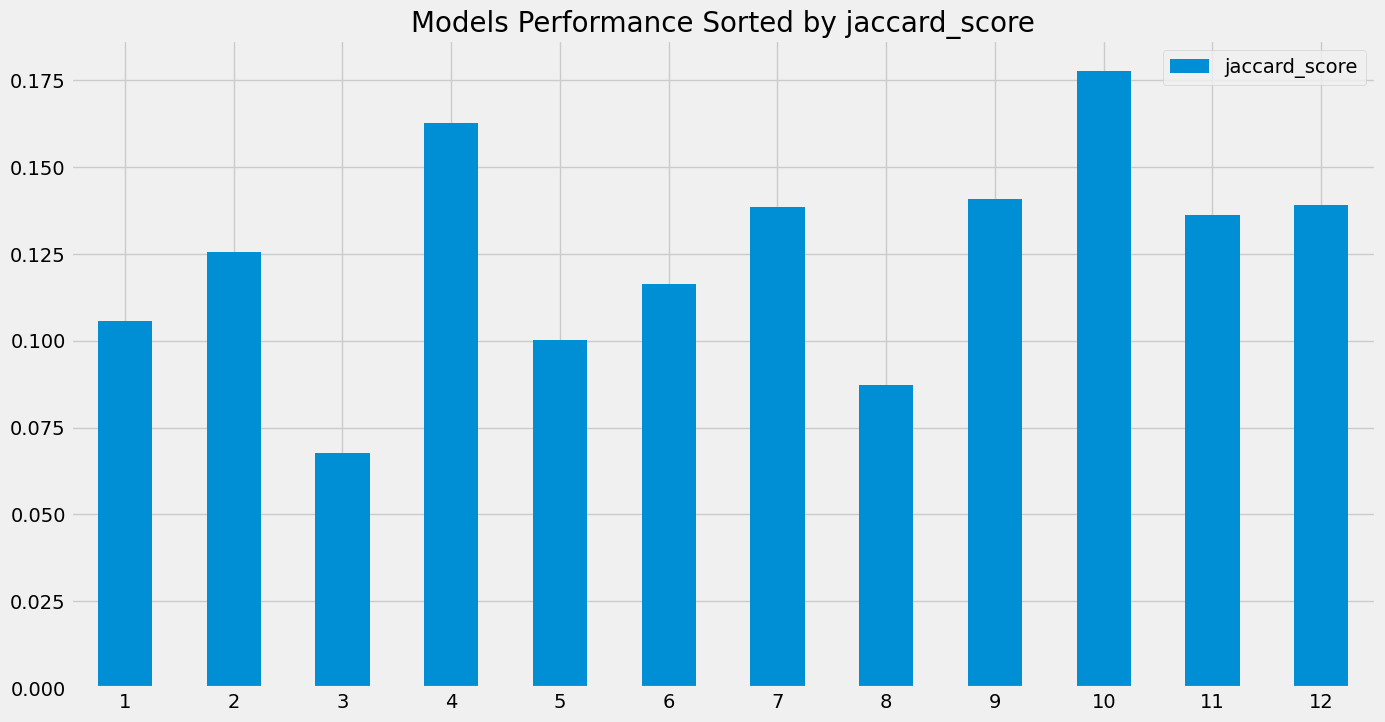

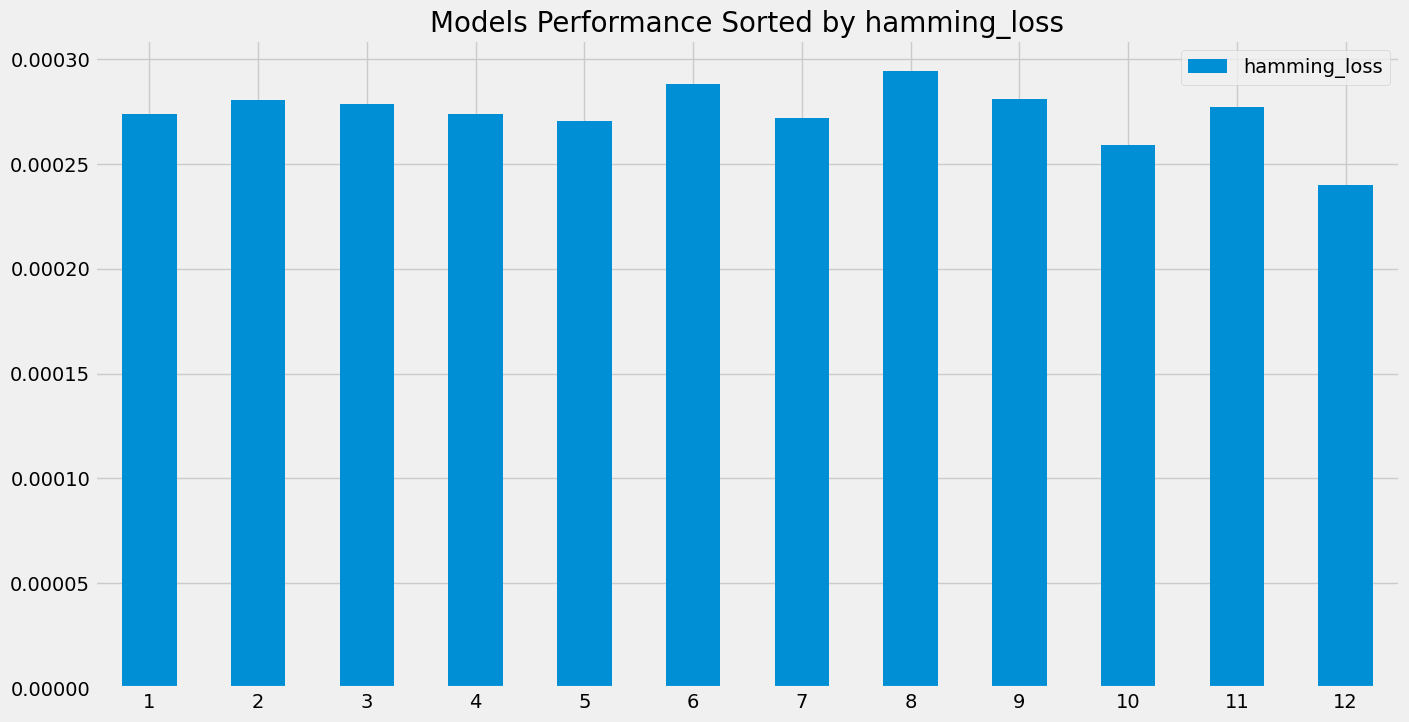


Stability verification script finished.



In [19]:
print("Starting stability verification script.\n")

if not exists(CACHED_2023_QUESTIONS_FILE):
    print(f"Cached questions are missing, downloading them in {CACHED_2023_QUESTIONS_FILE}.\n")
    cache_questions_from_2023()

cached_questions_2023 = load_cached_2023_questions()
print(f"\nNumber of questions of 2023 with a minimum of 10 votes: {len(cached_questions_2023)}.\n")
cached_questions_2023 = list(map(add_datetime_to_question, cached_questions_2023))

json_tags = json.load(open(TAGS_PATH, 'r'))
label_binarizer = start_label_binarizer(json_tags)
model = joblib.load(MODEL_PATH)

# unique_tags = set([tag for tags in json_tags.values() for tag in tags])
# cached_questions_2023 = [question for question in cached_questions_2023
#                          if all(tag in unique_tags for tag in question['tags'])]

results = []
for month in range(1, 13):
    current_month_questions = DataFrame([question for question in cached_questions_2023
                                         if question['creation_datetime'].month == month])
    print(f"Starting month:{month} verification with {len(current_month_questions)} questions.")

    y_test = label_binarizer.transform(current_month_questions['tags'])

    questions_without_tags = current_month_questions.drop(columns=['tags'], axis=1)
    x_test = transform_text_using_USE(questions_without_tags)

    predictions_test_y = model.predict(x_test)

    hamming_loss = metrics.hamming_loss(y_true=y_test, y_pred=predictions_test_y)
    jaccard_score = metrics.jaccard_score(y_true=y_test, y_pred=predictions_test_y, average='samples', zero_division=0)
    results.append({
        "month": month,
        "hamming_loss": hamming_loss,
        "jaccard_score": jaccard_score
    })

    print(f"Results of month:{month} - Hamming loss:{hamming_loss}, jaccard_score:{jaccard_score}.\n")

    send_scores_to_mlflow(results[-1])

create_results_plots(DataFrame(results))

print("\nStability verification script finished.\n")